In [1]:
import argparse, os
import utils
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import cucim.skimage.metrics as met


number of common Subjects  171


In [2]:
import torch
import os
import numpy as np
import torch
import random
import math
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from itertools import islice
import h5py
import os
np.seterr(all="ignore")

loaded = {}
loaded_gt ={}
shape_3t = [145,174,174]
shape_7t = [173,207,173]
shape_ratio = [round(shape_7t[i]/shape_3t[i],1) for i in range(3)]
path,tot = "",""


def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    act_ids = []
    print(shape_ratio)
    for i in ids:
        name = path['3T'][i]['h5']
        if(not os.path.isfile(name)):
            continue
        res_vol = h5py.File(name, 'r')
        
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:] }
        
        name = path['7T'][i]['GT']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:] }
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()
        act_ids.append(i)
    return act_ids


def interpolate(data,size):
    if(len(data.shape)==3):
        inp = torch.unsqueeze(data, 0)
    else:
        inp = torch.permute(data, (3,0,1,2))
    inp = torch.unsqueeze(inp, 0)
    interpolated = torch.nn.functional.interpolate(inp,size = torch.Size(size))
    interpolated = torch.permute(interpolated, (2,3,4,1,0))
    
    if(len(data.shape)==3):
        interpolated = torch.squeeze(interpolated)
    return torch.squeeze(interpolated)
    

In [18]:

import torchio as tio


class hcp_data(torch.utils.data.Dataset):
    def __init__(self, opt,ids):
        super(hcp_data).__init__()
        self.blk_size = opt.block_size
        self.thres = opt.thres
        self.base_dir = opt.dir if opt.dir != None else "/storage/users/arihant"
        self.ids = ids
        self.debug = opt.debug
        self.enable_thres = opt.enable_thres
        self.transform = tio.transforms.RescaleIntensity(masking_method=lambda x: x > 0)
        if(opt.sort == True):
            self.ids.sort()
            
        self.scale_strict = (1,1,1)
        self.preload_data(stable = True)


    def __len__(self):
        return self.blk_indx[-1]
        
    def __getitem__(self,indx):

        blk_idx = np.searchsorted(self.blk_indx, indx)
        vol_idx = self.ids[blk_idx]
        blk_idx = indx - self.blk_indx[blk_idx]
        if(self.debug):
            return self.loaded_blk[vol_idx][blk_idx,...],self.loaded_fa[vol_idx][blk_idx,...],self.loaded_adc[vol_idx][blk_idx,...],self.loaded_rgb[vol_idx][blk_idx,...],self.scale[vol_idx],self.blks_ret_lr[vol_idx][blk_idx,...],self.blks_ret_hr[vol_idx][blk_idx,...],vol_idx
        return self.loaded_blk[vol_idx][blk_idx,...],self.loaded_fa[vol_idx][blk_idx,...],self.loaded_adc[vol_idx][blk_idx,...],self.loaded_rgb[vol_idx][blk_idx,...],self.scale[vol_idx]
        

    def preload_data(self,stable = False,blk_size = None):
        
        if blk_size is not None:
            self.blk_size = blk_size
        if stable:
            self.scale_strict = (1,1,1)
        elif stable == False:
            self.scale_strict = None
        
        self.blk_indx = []
        self.loaded_blk = {}
        self.loaded_adc = {}
        self.loaded_fa = {}
        self.loaded_rgb = {}
        self.scale = {}
        self.blks_ret_lr = {}
        self.blks_ret_hr = {}
        for i in self.ids:
            self.loaded_blk[i],self.loaded_adc[i],self.loaded_fa[i],self.loaded_rgb[i],self.scale[i],self.blks_ret_lr[i],self.blks_ret_hr[i] = self.pre_proc(i)
            if(self.debug == True):
                print(i,"loaded")
        self.blk_indx = np.cumsum(self.blk_indx)

    
    def blk_points_pair(self,datalr,datahr,blk_size = [16,16,4],stride = (0,0,0),scale = (1,1,1)):
    
        shpind = torch.nonzero(datalr)
        xmin,xmax = torch.min(shpind[:,0]).item(),torch.max(shpind[:,0]).item()
        ymin,ymax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,1]).item()
        zmin,zmax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,2]).item()

        lr_start = [xmin,ymin,zmin]
        lr_end = [xmax - blk_size[0] + 1,ymax - blk_size[1] + 1,zmax - blk_size[2] + 1]

        shpind = torch.nonzero(datahr)
        xmin,xmax = torch.min(shpind[:,0]).item(),torch.max(shpind[:,0]).item()
        ymin,ymax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,1]).item()
        zmin,zmax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,2]).item()

        blk_size_hr = [round(blk_size[i]*scale[i]) for i in range(3)]
        hr_start = [xmin,ymin,zmin]
        hr_end = [xmax - blk_size_hr[0] + 1,ymax - blk_size_hr[1] + 1,zmax - blk_size_hr[2] + 1]

        a,b = [lr_end[i] - lr_start[i] for i in range(3)],[hr_end[i] - hr_start[i] for i in range(3)]
        offset = [round(b[i]/a[i],1) for i in range(3)]
        ranges_lr = [np.arange(lr_start[i], lr_end[i], blk_size[i] - stride[i]) for i in range(3)]
        ranges_hr = [np.round(ranges_lr[i]*offset[i]) for i in range(3)]
        
        # misc = {'offset': offset,
        #         'hr_pts': (hr_start,hr_end)}
        
        ind_block_lr = []
        ind_block_hr = []
        count = 0

        for ii in np.arange(0, ranges_lr[0].shape[0]):
            for jj in np.arange(0, ranges_lr[1].shape[0]):
                for kk in np.arange(0, ranges_lr[2].shape[0]):
                    x,y,z = ranges_lr[0][ii],ranges_lr[1][jj],ranges_lr[2][kk]
                    temp_lr = np.array([x, x + blk_size[0]-1, 
                                        y, y + blk_size[1]-1, 
                                        z, z + blk_size[2]-1]).astype(int)
                    
                    x,y,z = ranges_hr[0][ii],ranges_hr[1][jj],ranges_hr[2][kk]
                    temp_hr = np.array([x, x + blk_size_hr[0]-1,
                                        y, y + blk_size_hr[1]-1,
                                        z, z + blk_size_hr[2]-1]).astype(int)
                    
                    
                    curr_blk = datalr[temp_lr[0]:temp_lr[1]+1, temp_lr[2]:temp_lr[3]+1, temp_lr[4]:temp_lr[5]+1, ...]
                    curr_blk_hr = datahr[temp_hr[0]:temp_hr[1]+1, temp_hr[2]:temp_hr[3]+1, temp_hr[4]:temp_hr[5]+1, ...]
#                     print(curr_blk.size(),curr_blk.shape,curr_blk_hr.shape,curr_blk_hr.size())

                    if(self.enable_thres):
                        if((torch.numel(curr_blk) != 0 and torch.count_nonzero(curr_blk)/torch.numel(curr_blk) > self.thres) and 
                        (torch.numel(curr_blk_hr) != 0 and torch.count_nonzero(curr_blk_hr)/torch.numel(curr_blk_hr) > self.thres)):
                            ind_block_lr.append(temp_lr)
                            ind_block_hr.append(temp_hr)
                            count = count + 1
                    else:
                        ind_block_lr.append(temp_lr)
                        ind_block_hr.append(temp_hr)
                        count = count + 1
                    
        ind_block_lr = np.stack(ind_block_lr)
        ind_block_lr = ind_block_lr.astype(int)
        ind_block_hr = np.stack(ind_block_hr)
        ind_block_hr = ind_block_hr.astype(int)
        
        return ind_block_lr,ind_block_hr,len(ind_block_lr)


    def extract_block(self,data, inds):
            blocks = []
            for ii in np.arange(inds.shape[0]):
                inds_this = inds[ii, :]
                curr_blk = data[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1, ...]
                blocks.append(curr_blk)
            return np.stack(blocks, axis=0)

    def norm(self,data):
        if(len(data.size())<4):
            temp = self.transform(torch.unsqueeze(data,0))
            return torch.squeeze(temp)
        return self.transform(data)
    
    def pre_proc(self,idx):

        vol = torch.from_numpy(loaded[idx]['vol0'])
        if(self.scale_strict is not None):
            curr_scale = self.scale_strict
        else:
            x = np.around(np.random.uniform(1,1.9),decimals=1)
            asy = 0.1
            curr_scale = np.around(np.random.uniform(x-asy,x+asy,3),decimals=1)

        size = [int(curr_scale[i] * vol.shape[i]) for i in range(3)]
        
        vol_hr = interpolate(torch.from_numpy(loaded_gt[idx]['vol0']),size)
        adc = interpolate(torch.from_numpy(loaded_gt[idx]['ADC']),size)
        fa = interpolate(torch.from_numpy(loaded_gt[idx]['FA']),size)
        rgb = interpolate(torch.from_numpy(loaded_gt[idx]['color_FA']),size)
        
        # vol = self.norm(vol)
        adc,fa,rgb = self.norm(adc),self.norm(fa),self.norm(rgb)

        curr_blk = self.blk_points_pair(vol,vol_hr,blk_size=self.blk_size,scale=curr_scale)
        
        self.blk_indx.append(curr_blk[2])
        
        blks_img = self.extract_block(vol,curr_blk[0])
        blks_adc = self.extract_block(adc,curr_blk[1])
        blks_fa = self.extract_block(fa,curr_blk[1])
        blks_rgb = self.extract_block(rgb,curr_blk[1])
        
        return blks_img,blks_adc,blks_fa,blks_rgb,curr_scale,curr_blk[0],curr_blk[1]
    
    

In [36]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(16,16,4),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(64,64,16),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(2,1.5,1),
                    help="test_size")
parser.add_argument("--enable_thres", type=bool, default=True,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.scale = (1.5,1.4,1.2)
args.thres = 0.2
print(args)

Namespace(batch_size=4, block_size=(16, 16, 4), crop_depth=15, debug=True, dir='/storage', enable_thres=True, preload=True, ret_points=True, scale=(1.5, 1.4, 1.2), sort=True, test_size=(64, 64, 16), thres=0.2)


In [37]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
load_data(args.dir,ids)

[1.2, 1.2, 1.0]


['100610', '102311', '102816', '104416', '105923']

In [38]:
training_dataset = hcp_data(args,ids[0:1])

100610 loaded


In [39]:
idx = '100610'
sca = (1.3,1.4,1.4)
vol = torch.from_numpy(loaded[idx]['vol0'])
size = [int(sca[i] * vol.shape[i]) for i in range(3)]
vol_hr = interpolate(torch.from_numpy(loaded_gt[idx]['vol0']),size)
vol_norm = (vol-torch.min(vol))/(torch.max(vol)-torch.min(vol))

stride = (0,0,0)

In [40]:
loaded[idx]['vol0'].shape

(113, 147, 107, 7)

In [41]:
idx='100610'
vol_hr = interpolate(torch.from_numpy(loaded_gt[idx]['vol0']),size)
vol = torch.from_numpy(loaded[idx]['vol0'])
vol = (vol-torch.min(vol))/(torch.max(vol)-torch.min(vol))
vol_hr = (vol_hr-torch.min(vol_hr))/(torch.max(vol_hr)-torch.min(vol_hr))

In [56]:
curr_blk = training_dataset.blk_points_pair(vol,vol_hr,(16,16,4),(1.2,1.2,1),(2,2,2))

In [57]:
curr_blk

(array([[  0,  15,  29,  44,  27,  30],
        [  0,  15,  29,  44,  30,  33],
        [  0,  15,  29,  44,  33,  36],
        ...,
        [ 88, 103, 118, 133,  51,  54],
        [ 88, 103, 118, 133,  54,  57],
        [ 88, 103, 118, 133,  57,  60]]),
 array([[  0,  31,  38,  69,  38,  45],
        [  0,  31,  38,  69,  42,  49],
        [  0,  31,  38,  69,  46,  53],
        ...,
        [107, 138, 154, 185,  71,  78],
        [107, 138, 154, 185,  76,  83],
        [107, 138, 154, 185,  80,  87]]),
 1374)

In [58]:
lr = curr_blk[0]

In [59]:
curr_blk[1][:,::2]

array([[  0,  38,  38],
       [  0,  38,  42],
       [  0,  38,  46],
       ...,
       [107, 154,  71],
       [107, 154,  76],
       [107, 154,  80]])

In [60]:
ava = []
from matplotlib.patches import Rectangle
for i in range(len(curr_blk[0])):
#     print(curr_blk[0][i])
    img_pnt = curr_blk[0][i]
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ava.append(sliceee)
#     print(sliceee)

In [63]:
ava = list(set(ava))
print(len(ava))
log = {}
k=0
for i in range(len(ava)//2):
    log[ava[i*2]] = (k,0)
    log[ava[(i*2)+1]] = (k,1)
    k+=1

35


In [65]:
vol_hr.shape

torch.Size([146, 205, 149, 7])

In [77]:
((img_pnt[5]-img_pnt[4])//2)+img_pnt[4]

142

In [75]:
((img_pnt[5]-img_pnt[4])//2)

3

In [76]:
img_pnt[5]

146

In [71]:
img_pnt

array([ 36,  67,  58,  89, 139, 146])

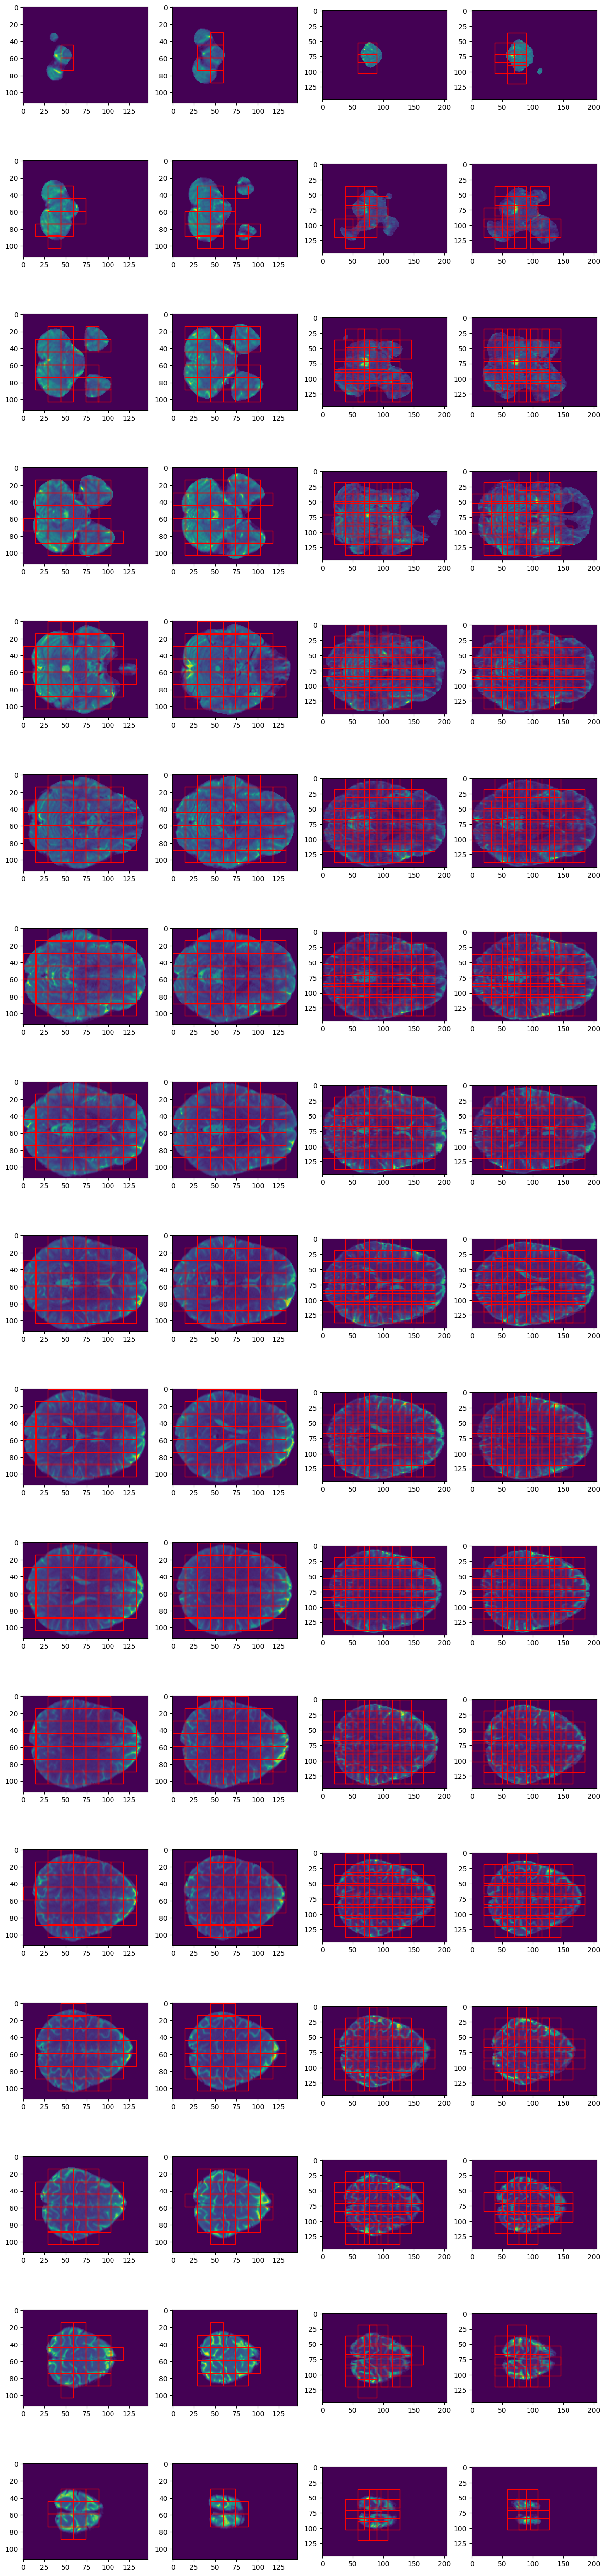

In [78]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
l = len(log)//2
fig, ax = plt.subplots(l,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)
k=0
for i in range(len(curr_blk[0])):
    
    img_pnt = curr_blk[0][i]
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[4]
#     print(sliceee)
    if sliceee in log.keys():
        
        temp = log[sliceee]

        ax[temp[0]][temp[1]].imshow(vol[:,:,sliceee,0])
        ax[temp[0]][temp[1]].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
        
        img_pnt = curr_blk[1][i]
        y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
        sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[4]
        
        ax[temp[0]][temp[1]+2].imshow(vol_hr[:,:,sliceee,0])
        ax[temp[0]][temp[1]+2].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    
    
    
plt.show()